# WaiDatathon 2021

# Content

1. #### [Problem description](#prob)
1. #### [Setup](#setup)
1. #### [Data description](#descr)
1. #### [Data cleaning](#clean)
1. #### [Exploratory data analysis](#EDA)
1. #### [Modeling](#model)
    1. #### [Single variable model](#model)
    1. #### [Multivariate model](#model)
    

<a id="prob"></a>
<p style="color:darkred; font-family:Futura; font-size:40px">1. Problem description</p>
The WaiDatathon 2021 was oragnized by Women in AI on the theme "Combat Domestic Violence with Data & AI" (https://www.womeninai.co/waidatathon-details). This notebook reproduces our main analysis. We proposed a machine learning model that creates a questionnaire to detect early signs of domestic violence. Because the model can be deployed on paper or by dialogue, it is especially suited for developing countries. We used the amazing data from The Demographic and Health Surveys (DHS) Program. You can watch our 5-minute talk here: https://lnkd.in/gBupkte

For the competition we used data of the DHS survey for Benin and Congo. To comply with copyright requirements only the example data of the DHS survey can be contained in the github repository. This notebook should can be used to treat any survey data from the DHS for phase VII (note: is that correct?). Since the survey questions evolved are revised from one phase to another, some adjustements might be needed to process data from other DHS phases.

<a id="setup"></a>
<p style="color:darkred; font-family:Futura; font-size:40px">2. Setup</p>

In [2]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('seaborn')
mpl.rc('font', size=18)
mpl.rc('axes', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

plt.rcParams['figure.figsize'] = [20, 10] # For larger plots

In [3]:
# Load data
df_IR = pd.read_stata("./Data/DHS/BJIR71DT/BJIR71FL.DTA", convert_categoricals=False)
# df_IR = pd.read_stata("./Data/DHS/CDIR61DT/CDIR61FL.DTA", convert_categoricals=False)


Then, let's define a subset of features to use

In [3]:
# Subset of features
# background

edu = 'v106'
violence_justified = 'v744' # a-e
age = 'v012'
age_group = 'v013'
litteracy = 'v155'
media_paper = 'v157'
media_radio = 'v158'
media_tv = 'v159'
sample_weight = 'v005' # must be divided by 1e6
ever_married = 'v020'
# residence = 'v025'
time2water = 'v115'

has_elec = 'v119'
has_radio = 'v120'
has_tv = 'v121'

has_fridge='v122'
has_bicycle = 'v123'
has_moto = 'v124'
has_car = 'v125'
religion = 'v130'
ethnicity = 'v131'
place_of_residence = 'v134'
edu_attainment = 'v149'
relation2household_head='v150'
sex_household_head = 'v151'
age_household_head = 'v152'

has_phone_landline='v153'
has_phone_mobile='v169a'
use_internet = 'v171a'
use_internet_last_month = 'v171b'
wealth_index = 'v191'

total_child_born = 'v201'
num_sons_died = 'v206'
num_daughters_died = 'v207'
num_dead_child = 'num_dead_child'
num_living_child = 'v218'


selected_for_dom_violence_interview = 'v044'

husband_edu_level = 'v701'# 's904'
husband_occupation = 's908a'
resp_occupation = 's913a'

# Domestic violence
is_currently_in_union= 'v502'
weight_dom_violence = 'd005'
control_issues = 'd101' #a-j
num_control_issues = 'd102'
emotional_violence = "d103" # a-f
emotional_violence_any = 'emotional_violence_any' #'d104'
physical_violence = 'd105' # a-n detailed acts of violence
physical_violence_less_severe = 'd106'
physical_violence_severe = 'd107'
sexual_violence = 'd108'

violence = 'violence'
# any_violence = 'd105' or 'd106' or 'd107'

violence_to_husband ='d112'
partner_drinks_alcohol='d113'
partner_drinks_alcohol_freq = 'd114'
sought_help = 'd119' # a to xk; y=no one
mother_beaten = 'd121'


edu_w = 'v106' # education level women, value =0-3
edu_m = 'mv106' # education level men, 
#Age (v012) is recorded in
#completed years, and is typically reported in 5-year groups (v013). 
# age_group_w = "v013"
# Info for men is in the Men's individual recode (MR) dataset



list_col0 = ['caseid', 'v000', sample_weight,
            edu, age, age_group, litteracy,
            media_paper, media_radio, media_tv,
            ever_married, 
            has_elec, has_radio, has_tv, has_fridge, has_bicycle, has_car, has_moto, 
            has_phone_landline, 
#             has_phone_mobile,
            religion, ethnicity,
            place_of_residence, age_household_head,
            relation2household_head,
            wealth_index,
            total_child_born, num_living_child, 
            
            husband_edu_level,
#             husband_occupation, resp_occupation,
            
            
            selected_for_dom_violence_interview, weight_dom_violence,
            is_currently_in_union, num_control_issues, #emotional_violence_any, 
            physical_violence_less_severe, physical_violence_severe, sexual_violence,
            partner_drinks_alcohol, partner_drinks_alcohol_freq, #sought_help,
            mother_beaten
           ]



# 2. Data cleaning

In [4]:
# Prepare clean format for multiple questions

# Violence_justified
# =======
'''
V744A                  Beating justified if wife goes out without tell 6103    1    N    I    1    0   No   No
                               0  No
                               1  Yes
                               8  Don't know
                           (m) 9  Missing
                          (na)    Not applicable
'''
# I assume 0 if v744 in [0, 8, 9, na]; 1 otherwise


# Control issues
# =======
'''
D101A                  Husband/partner jealous if respondent talks wit 8272    1    N    I    1    0   No   No
                               0  No
                               1  Yes
                               8  Don't know
                           (m) 9  Missing
                          (na)    Not applicable
'''
# For cleaning: same as previous

# Physical or sexual violence
# =======
'''
D105A                  Ever been pushed, shook or had something thrown 8291    1    N    I    1    0   No   No
                               0  Never
                               1  Often
                               2  Sometimes
                               3  Yes, but not in the last 12 months
                               4  Yes, but frequency in last 12 months missing
                           (m) 9  Missing
                          (na)    Not applicable
'''
# Let's consider true if hit during the past 12 months only
# So, we clean as 0 if d105a in [0, 2,3,4,9,na]


# Emotional violence
# =======
'''
D103A                  Ever been humiliated by husband/partner         8284    1    N    I    1    0   No   No
                               0  Never
                               1  Often
                               2  Sometimes
                               3  Yes, but not in the last 12 months
                               4  Yes, but frequency in last 12 months missing
                           (m) 9  Missing
                          (na)    Not applicable
'''
# Same as physicial violence for cleaning



cleaning_dict = {
     violence_justified: {'num_questions': 5, 'values_0': [8,9]},
     control_issues:     {'num_questions': 10, 'values_0': [8,9]},
     physical_violence:  {'num_questions': 14, 'values_0': [2,3,4,9]},
     emotional_violence: {'num_questions': 6, 'values_0': [2,3,4,9]},
     }
        

In [5]:
# Add multiple questions to list_col
list_col = list_col0.copy()
for key in cleaning_dict.keys():
    cleaning_dict[key]['list_col'] = [key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]
    list_col += cleaning_dict[key]['list_col']

In [6]:
# Create a subset dataframe that contains only the chosen columns 
# and only for women who are married and took the domestic violence interview
df = df_IR[list_col].copy()
df = df[df[is_currently_in_union]==1]
df = df[df[selected_for_dom_violence_interview]==1]


In [7]:
for key in cleaning_dict.keys():
    df[key + '_sum'] = 0
    for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]:
        df[key + letter].fillna(0, inplace=True) # There shouldn't be missing na because of preselection of samples, but just in case
        for i in cleaning_dict[key]['values_0']:
            df.loc[df[key +  letter] == i,key + letter] = 0
        df[key + '_sum'] += df[key +  letter]
        
        # Check that assignment is correct
        assert df[key + letter].max() <= 1
#         print(key + letter + ":", df[key + letter].max())

In [8]:
# Feature engineering
df[num_dead_child] = df[total_child_born] - df[num_living_child]

In [9]:
# Weighting features
# df[violence_justified + '_weighted'] = df[violence_justified]*df[sample_weight]/1e6
# df[violence + '_weighted'] = df[violence]*df[sample_weight]/1e6



# 3. Exploratory data analysis

d105_sum,0.0,1.0
v744_sum,,
0,2762,100
1,1234,89


<AxesSubplot:title={'center':'Number of respondents for each class of score (only respondent experiencing domestic violence)'}, xlabel='v744_sum', ylabel='1.0'>

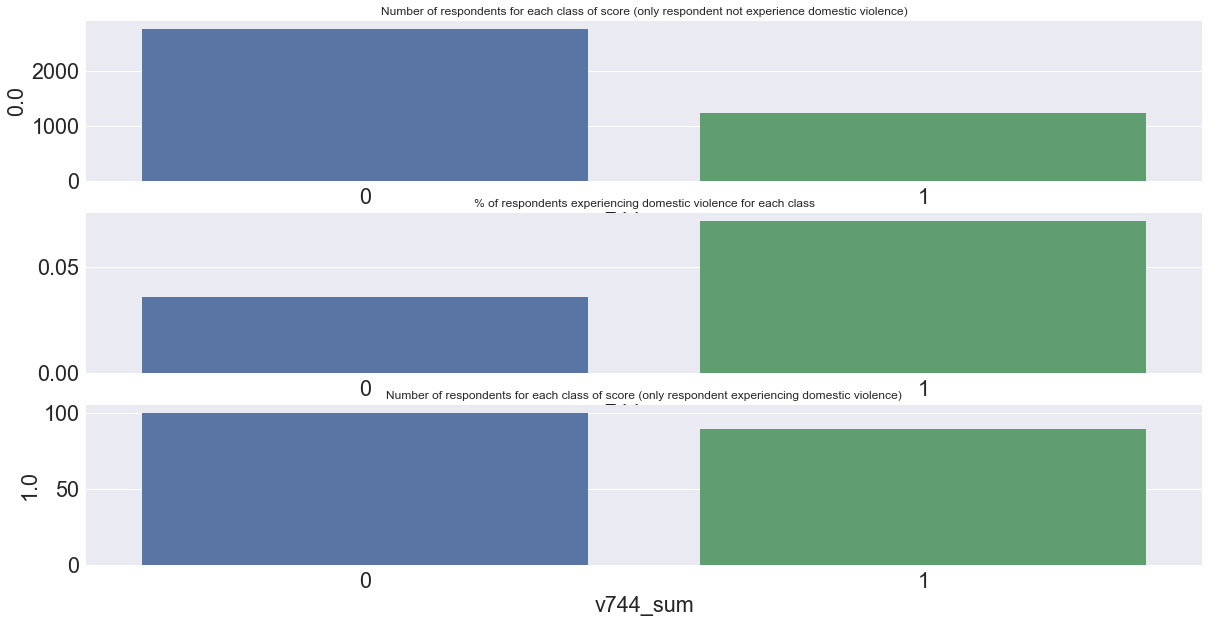

In [10]:
temp = df[[violence_justified + '_sum', physical_violence + '_sum']].copy()
temp['value'] = 1
temp.loc[temp[physical_violence + '_sum']>=1, physical_violence + '_sum']=1
temp.loc[temp[violence_justified + '_sum']>=1, violence_justified + '_sum']=1
temp_pivot = temp.pivot_table(columns=[physical_violence + '_sum'],
                              index=[violence_justified + '_sum'],
                              values='value',aggfunc='count')
display(temp_pivot)

plt.subplot(311)
plt.title('Number of respondents for each class of score (only respondent not experience domestic violence)')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,0])
plt.subplot(312)
plt.title('% of respondents experiencing domestic violence for each class')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,1]/temp_pivot.loc[:,0])
plt.subplot(313)
plt.title('Number of respondents for each class of score (only respondent experiencing domestic violence)')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,1])


- subplot(1) most respondents answered no to every question (ie v744_sum == 0)
- subplot(2) Given the v744 score, the probability to experience violence is higher for higher scores (i.e., P(A|B), where A is score and B is violence)
- subplot(3) since there are many more people with a score of 0, most people experiencing violence scored 0 (i.e. P(B|A))

The results from subplot 2 and 3, are typical examples of bayesian probability.


<AxesSubplot:xlabel='d105_sum', ylabel='v744_sum'>

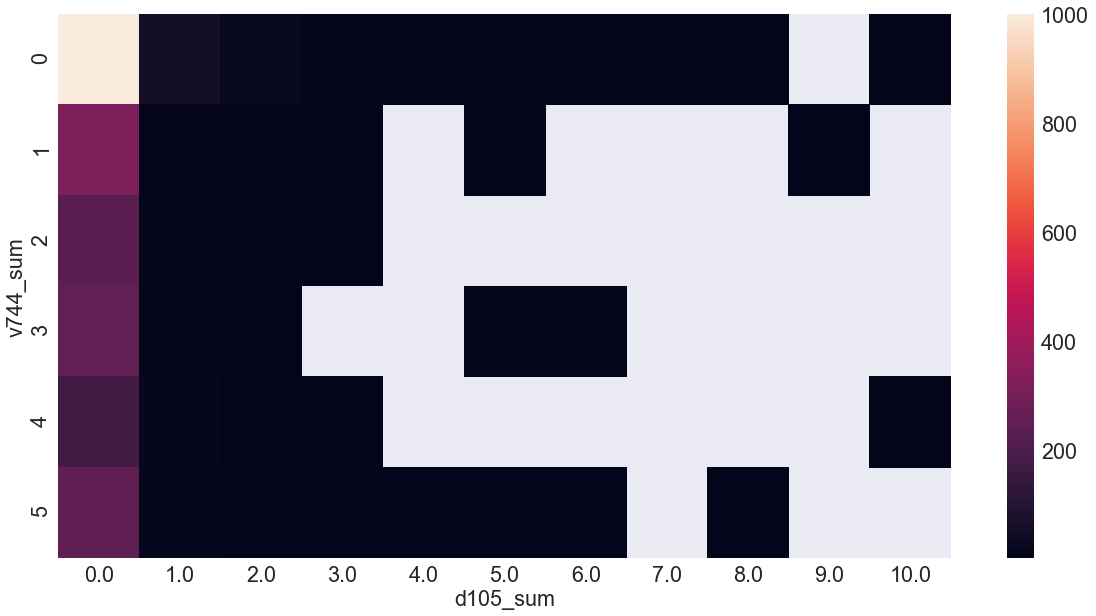

In [11]:
temp = df[[violence_justified + '_sum', physical_violence + '_sum']].copy()
temp['value'] = 1
# temp.loc[temp[physical_violence + '_sum']>=1, physical_violence + '_sum']=1
# temp.loc[temp[violence_justified + '_sum']>=1, violence_justified + '_sum']=1
temp_pivot = temp.pivot_table(columns=df[physical_violence + '_sum'],
                              index=[violence_justified + '_sum'],
                              values='value',aggfunc='count')

sns.heatmap(temp_pivot,vmax=1000)

### What is the most common form of physical+sexual domestic violence?

In [12]:
key = physical_violence
physical_violence_questions_sum = df[[key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]].sum()
num_physical_violence_respondent = (df[physical_violence + '_sum']>0).sum()

<AxesSubplot:>

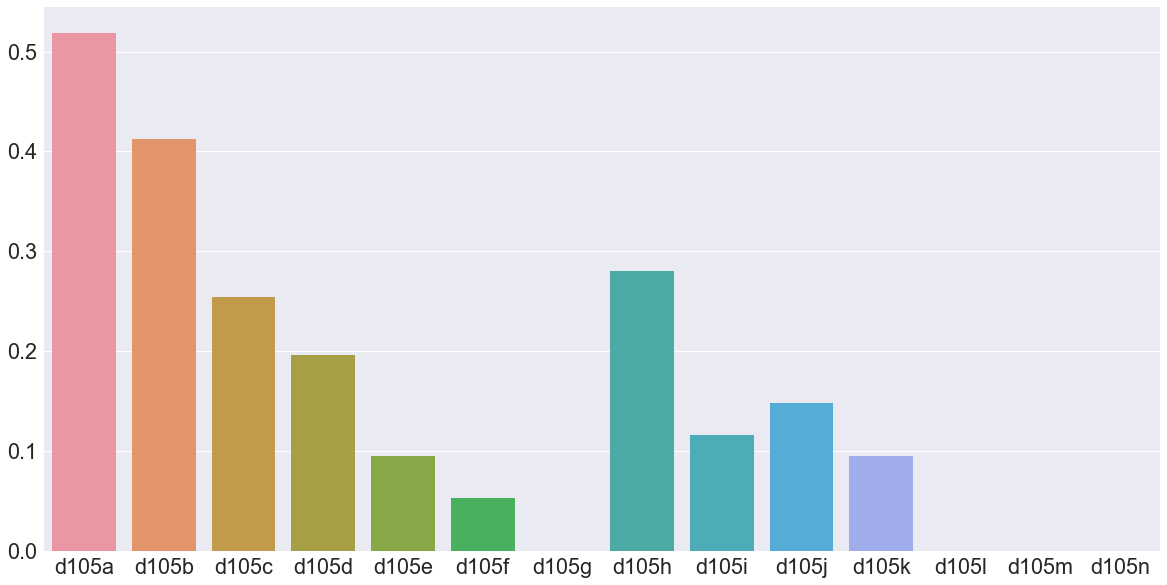

In [13]:
sns.barplot(y=physical_violence_questions_sum/num_physical_violence_respondent, x=physical_violence_questions_sum.index)

### What are forms of violence that occur together?
    
    

In [14]:
list_col_a = cleaning_dict[emotional_violence]['list_col']
list_col_b = cleaning_dict[physical_violence]['list_col']
list_col = list_col_a + list_col_b
temp = df[[emotional_violence + "_sum", physical_violence + "_sum"]].copy()
# temp_phy = df[physical_violence + "_sum"]

temp[emotional_violence + "_sum"] = temp[emotional_violence + "_sum"]>0
temp[physical_violence + "_sum"] = temp[physical_violence + "_sum"]>0

temp.loc[temp[emotional_violence + "_sum"]==1,physical_violence + "_sum"].sum()/temp.shape[0]
# temp.sum()/temp.shape[0]*100
(df[cleaning_dict[physical_violence]['list_col']].sum(axis=1)>0).sum()
# temp[emotional_violence + "_sum"].sum()
# # temp = df[list_col]
# co_occurence = (temp.T@temp)#.values
# for i in range(co_occurence.shape[0]):
#     co_occurence.iloc[i,:] /= co_occurence.iloc[i,i]
    
# sns.heatmap(co_occurence*100,annot=True)
# _ = plt.title("Co-occurence of positive physical or sexual violence acts in the last 12 months")

189

In [30]:
# Select some features for mutual information analysis
# list_col_model = [edu, age, age_group, litteracy,
#             media_paper, media_radio, media_tv,has_elec, has_radio, has_tv, has_fridge, has_bicycle, has_car, has_moto, 
#             has_phone_landline, 
# #             has_phone_mobile,
#             religion, ethnicity,
# #             place_of_residence, 
#             age_household_head,
#             relation2household_head,
#             wealth_index,
#             total_child_born, num_living_child, num_dead_child, 
            
            
#             husband_edu_level, 
# #             num_control_issues,
#             partner_drinks_alcohol, partner_drinks_alcohol_freq,
#             control_issues + '_sum',
#             violence_justified + '_sum',
# #             violence_justified,
#             emotional_violence + '_sum',
# #             emotional_violence_any,
#             physical_violence + '_sum',
            
#             mother_beaten,
# #             husband_occupation, resp_occupation,
#             ]
list_col_model = [
            litteracy,
            age,      
            mother_beaten,
            wealth_index,
            num_living_child,
            edu,      
            husband_edu_level, 
#             partner_drinks_alcohol, 
            partner_drinks_alcohol_freq,
            control_issues + '_sum',
            violence_justified + '_sum',
            emotional_violence + '_sum',
            physical_violence + '_sum',
            ]
X = df[list_col_model].copy()
explicit_feature_names = [
    'Literacy', 
    'Age', 
    'Did your father ever beat your mother', 
    'wealth index', 
    'number of children',
    'Education level', 
    "Husband's education level", 
#     "Does your husband drink alcohol?",
    'How often does your husband drink alcohol?', 
    'Is your husband jealous, or not not trusting you with money?',
    'Is a husband justified to beat his wife?',
    'Have you ever been humiliated, insulted or threatened by your husband?',
#     'Physical violence'
    ]


# for key in cleaning_dict.keys():
#     cleaning_dict[key]['list_col'] = [key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]
#     list_col += cleaning_dict[key]['list_col']

# X.loc[:,husband_occupation] = X.loc[:,husband_occupation].astype('int8') # /!\ contains "8" as Nan
# X.loc[:,resp_occupation] = X.loc[:,resp_occupation].astype('int8') # /!\ contains "8" as Nan

# replace not applicable by "doesn't drink" for alcohol related question
for col in [partner_drinks_alcohol_freq, mother_beaten]:
# for col in [partner_drinks_alcohol, partner_drinks_alcohol_freq, mother_beaten]:
    X[col].fillna(0, inplace=True)
    


# feature engineering
age_diff = 'age_diff'
age_ratio = 'age_ratio'
# X[age_diff] = X[age] - X[age_household_head]

X.loc[:,'v701'].fillna(0,inplace=True) # only 2 missing values in Congo, 0 in Benin

X.loc[X[litteracy]>=3,litteracy] = 0
X.loc[X[litteracy]<=1,litteracy] = 0
X.loc[X[litteracy]==2,litteracy] = 1


# cast the following columns as int8 to treat them as discrete features
for col in [ partner_drinks_alcohol_freq, mother_beaten, #relation2household_head,
           husband_edu_level]:#, emotional_violence_any]: 
# for col in [partner_drinks_alcohol, partner_drinks_alcohol_freq, mother_beaten, relation2household_head,
#            husband_edu_level]:#, emotional_violence_any]: 
    X.loc[:,col] = X.loc[:,col].astype('int8') # /!\ contains "8" as Nan

    
# cast the following columns a floats continuous features
# for col in [total_child_born, num_living_child, num_dead_child, age, age_household_head, age_diff,
#            violence_justified + '_sum', 
#             emotional_violence + '_sum',
#             physical_violence + '_sum', 
#             control_issues + '_sum',
#             wealth_index]:
for col in [num_living_child, #num_dead_child, total_child_born, 
            age, #age_household_head, age_diff,
            violence_justified + '_sum', 
            emotional_violence + '_sum',
            physical_violence + '_sum', 
            control_issues + '_sum',
            wealth_index]:
    X[col] = X[col].astype(float)


    
discrete_features = X.dtypes == 'int8'
X.dropna(inplace=True)
# X.dropna().info()

In [31]:
# dict(zip(X.columns,explicit_feature_names))
# X.info()

In [32]:
# Mutual information classification
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores



def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores", fontsize=25)


In [33]:
# Let's try subsampling the majority class (no violence) to get better classification on the minority class (i.e. the class of interest)
from sklearn.model_selection import train_test_split

def subsample(X,y,imbalance_fac=1):
    y_select = df[physical_violence + "_sum"]>0
    y_negative = y[y_select==0].copy()
    y_positive = y[y_select==1].copy()
    
    X_negative = X.loc[y_select==0,:].copy()
    X_positive = X.loc[y_select==1,:].copy()
    
#     # duplicate positive cases
#     for i in range(4):
#         y_positive = np.concatenate([y_positive, y_positive])
#         X_positive = np.concatenate([X_positive, X_positive],axis=0)
    
    # subsample negative cases
    _, X_negative_sub, _, y_negative_sub = train_test_split(X_negative,y_negative, test_size=imbalance_fac*len(y_positive))#, stratify=True )
    return (pd.DataFrame(np.concatenate([X_negative_sub,X_positive]), columns=X.columns), 
            pd.Series(np.concatenate([y_negative_sub,y_positive]), ))


# y = df[violence_justified + '_sum']>0
# this_X = X.drop(columns=[violence_justified + "_sum"] )# +cleaning_dict[violence_justified]['list_col'])
# this_X, y = subsample(this_X,y)      
# y.shape

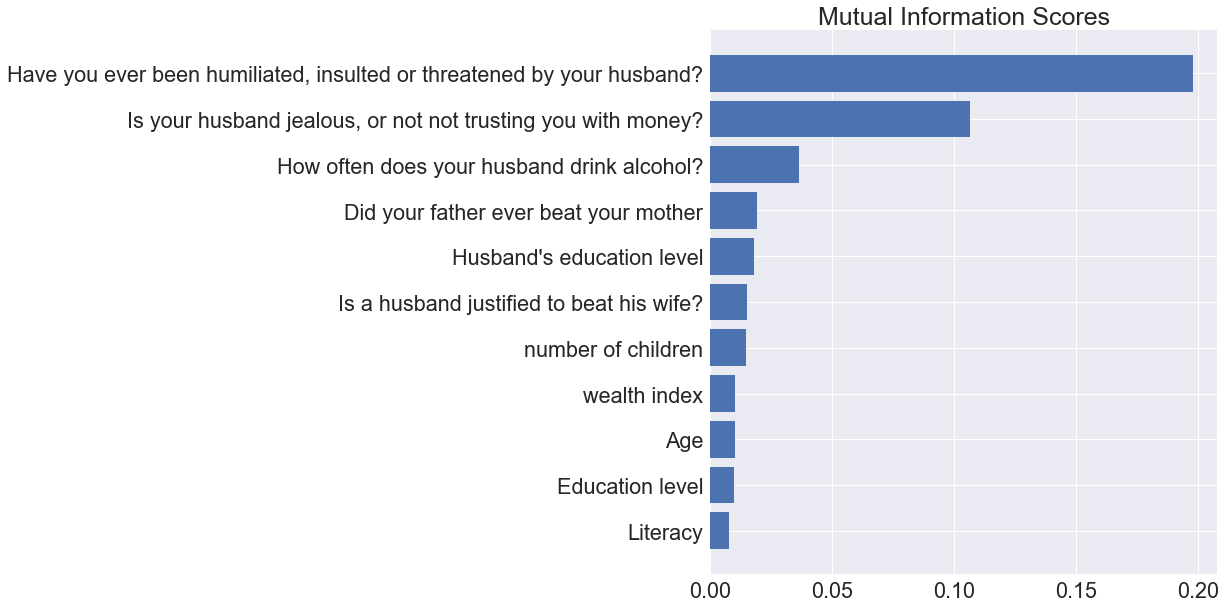

In [34]:
# for itarget, target_feature in enumerate([violence_justified, physical_violence]):
for itarget, target_feature in enumerate([physical_violence]):    
    y = X[target_feature + '_sum']>0
    
    plt.subplot(1,2,itarget+1)
    this_X = X.drop(columns=[target_feature + "_sum"] )
    discrete_features = this_X.dtypes == 'int8'
    mi_scores = pd.Series(np.zeros(this_X.columns.shape), index= this_X.columns)
    n = 20
    for i in range(n):
        X_sub, y_sub = subsample(this_X,y)     
        
        mi_scores += 1.0/n*make_mi_scores(X_sub, y_sub, discrete_features)
        
    mi_scores.rename(dict(zip(X.columns,explicit_feature_names)), inplace=True)
    plot_mi_scores(mi_scores)


In [35]:
# Clean up missing values
# X.info()
for col in X.columns:
    print(col + ": ", X[col].unique())

v155:  [0 1]
v012:  [28. 39. 43. 44. 36. 16. 48. 19. 25. 35. 30. 21. 17. 22. 46. 38. 18. 20.
 29. 23. 33. 24. 15. 42. 41. 32. 27. 40. 47. 37. 26. 49. 34. 45. 31.]
d121:  [0 8 1]
v191:  [-51108. -78127. -59017. ...  40666.  99925. 291577.]
v218:  [ 4.  3.  1.  0.  6.  2.  5.  7.  8.  9. 10. 11. 12.]
v106:  [0 2 1 3]
v701:  [0 1 2 3 8]
d114:  [0 2 1]
d101_sum:  [2. 5. 4. 1. 0. 3.]
v744_sum:  [3. 4. 0. 5. 1. 2.]
d103_sum:  [0. 1. 2. 3.]
d105_sum:  [ 0.  1.  5.  3.  2.  4.  6. 10.  8.  7.  9.]


# Let's try prediction

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score
y = X[physical_violence + "_sum"]>0
this_X = X.drop(columns=[physical_violence + "_sum"])
this_X.columns
discrete_features = this_X.dtypes == 'int8'
X_model = pd.get_dummies(this_X, columns=this_X.columns[discrete_features])
imbalance_fac = 1
X_model, y = subsample(X_model,y, imbalance_fac=imbalance_fac)      
X_train, X_test, y_train, y_test = train_test_split(X_model.values,y.values, test_size=0.2)

param_grid = dict(max_depth=[9], 
                  min_samples_leaf=[0.05, 0.07, 0.1, 0.15, 0.2, 0.25, .3, 0.5],
                 )

 
clf = DecisionTreeClassifier(min_impurity_decrease=0.0001,
                             class_weight={0:1, 1:imbalance_fac}, 
                             )

clf_cv = GridSearchCV(clf, param_grid, cv=3, scoring='recall')


clf_cv.fit(X_train, y_train)
display(clf_cv.best_params_)
y_pred = clf_cv.best_estimator_.predict(X_test)

print(confusion_matrix(y_test, y_pred)/y_test.shape[0])
classif_dict = classification_report(y_test,y_pred, output_dict=True)
print("f1_score:", classif_dict['True']['f1-score'])
print(classification_report(y_test,y_pred))

{'max_depth': 9, 'min_samples_leaf': 0.1}

[[0.38157895 0.10526316]
 [0.13157895 0.38157895]]
f1_score: 0.7631578947368421
              precision    recall  f1-score   support

       False       0.74      0.78      0.76        37
        True       0.78      0.74      0.76        39

    accuracy                           0.76        76
   macro avg       0.76      0.76      0.76        76
weighted avg       0.76      0.76      0.76        76



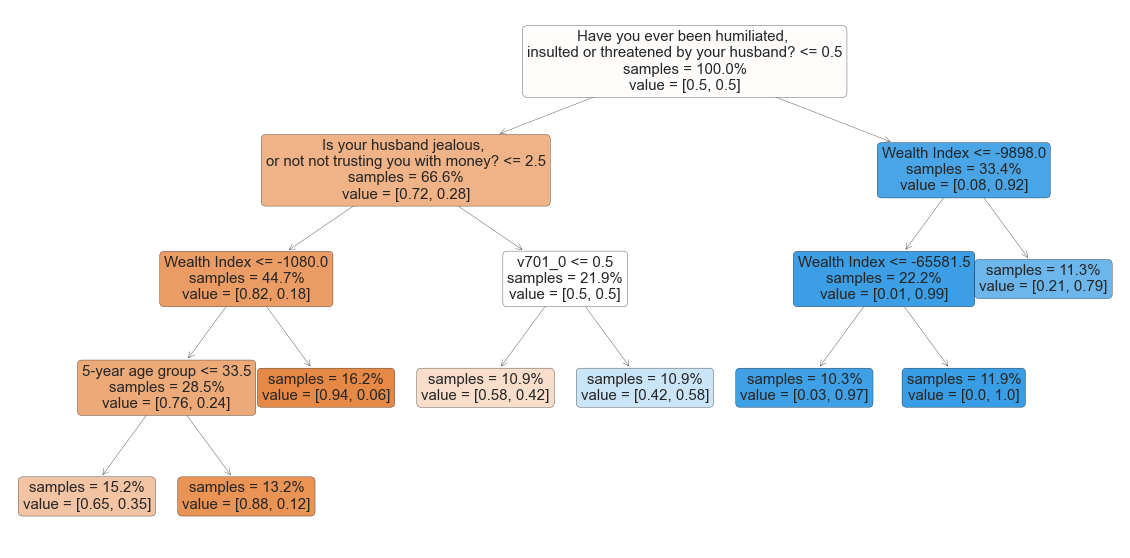

In [60]:
expl_feature_names_model =(list(X_model.columns.copy()))
# expl_feature_names_model.rename({'v012':  '5-year age group'}, inplace=True)

expl_feature_names_model[:6] = [
    '5-year age group', 
    'Wealth Index',
    'Number of children',
    'Is your husband jealous, \nor not not trusting you with money?',
    'Is a husband justified to beat his wife?',
    'Have you ever been humiliated, \ninsulted or threatened by your husband?',
]
# fig, ax = plt.subplots(1,1)
# _ = tree.plot_tree(clf_cv.best_estimator_, feature_names=X_model.columns, filled=True, 
#                    impurity=False, proportion=True, precision=2, rounded=True)
_ = tree.plot_tree(clf_cv.best_estimator_, feature_names=expl_feature_names_model, filled=True, 
                   impurity=False, proportion=True, precision=2, rounded=True,fontsize=15)

# _ = tree.plot_tree(clf, feature_names=X_model.columns)

In [29]:
X_model.columns

Index(['v012', 'v191', 'v218', 'd101_sum', 'v744_sum', 'd103_sum', 'v155_0',
       'v155_1', 'd121_0', 'd121_1', 'v106_0', 'v106_1', 'v701_0', 'v701_1',
       'd114_0', 'd114_1'],
      dtype='object')

In [24]:

#     'Litteracy',
    
#     'Did your father ever beat your mother', 

    
#     'Education level', 
#     "Husband's education level", 
# #     "Does your husband drink alcohol?",
#     'How often does your husband drink alcohol?', 
    
    
    
# #     'Physical violence'
#     ]

In [25]:
np.sum(np.abs(y_test.values-y_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
np.sum(y_test.values.astype(int) - y_pred.astype(int))

In [ ]:
cleaning_dict

In [ ]:
# For Ettore
df[cleaning_dict['v744']['list_col'] + cleaning_dict['d105']['list_col'] + cleaning_dict['d103']['list_col']].astype(int).to_csv('data_Ettore.csv')

In [ ]:
mi_benin = mi_scores.copy()

In [ ]:
mi_congo = mi_scores.copy()

In [ ]:
mpl.rc('font', size=30)
fig = plt.figure(figsize=[20,15])
for i, scores in enumerate([mi_benin, mi_congo]):
    width = 2*np.arange(len(scores))
    scores = scores.sort_values(ascending=True)
    plt.barh(-0.8*i+width, scores)



ticks = list(scores.index)


plt.yticks(width, ticks)
plt.title("Mutual Information Scores", fontsize=40)
